# Phase 2: Diabetes Prediction using MyTorch

In this phase, we implement an MLP using the custom MyTorch library (without PyTorch or TensorFlow).

**Goal**: Achieve at least 70% train accuracy and 60% test accuracy on the diabetes dataset.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from mytorch import Tensor
from mytorch.model import Model
from mytorch.layer import Linear
from mytorch.activation import sigmoid, relu
from mytorch.loss import MeanSquaredError
from mytorch.optimizer import SGD

np.random.seed(42)

## 2. Load and Preprocess Data

In [2]:
# Load dataset
FILE_PATH = 'diabetes.csv'
df = pd.read_csv(FILE_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (768, 9)

First few rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Separate features and labels

X = df.iloc[:, :-1].values  # 8 features
y = df.iloc[:, -1].values.reshape(-1, 1)  # binary label (0 or 1)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y.flatten().astype(int))}")

Features shape: (768, 8)
Labels shape: (768, 1)
Class distribution: [500 268]


In [4]:
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                   'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_features = pd.DataFrame(X, columns=feature_columns)

for col in zero_not_accepted:
    df_features[col] = df_features[col].replace(0, np.nan)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Preprocessed features shape: {X_scaled.shape}")
print(f"Feature mean: {X_scaled.mean():.4f}, std: {X_scaled.std():.4f}")

Preprocessed features shape: (768, 8)
Feature mean: 0.0000, std: 1.0000


In [5]:
# Split data: 60% train, 20% validation, 20% test
# First split: 60% train, 40% temp (for val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: Split temp into 50/50 (20% val, 20% test of original)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"\nTrain class distribution: {np.bincount(y_train.flatten().astype(int))}")
print(f"Validation class distribution: {np.bincount(y_val.flatten().astype(int))}")
print(f"Test class distribution: {np.bincount(y_test.flatten().astype(int))}")

Train set: 460 samples (59.9%)
Validation set: 154 samples (20.1%)
Test set: 154 samples (20.1%)

Train class distribution: [299 161]
Validation class distribution: [100  54]
Test class distribution: [101  53]


## 3. Define MLP Model using MyTorch

In [6]:
class DiabetesMLP(Model):
    
    def __init__(self, input_size=8, hidden1=64, hidden2=32, output_size=1):
        super().__init__()
        
        # Define layers without bias to avoid autograd issues
        self.fc1 = Linear(input_size, hidden1, need_bias=False, mode='xavier')
        self.fc2 = Linear(hidden1, hidden2, need_bias=False, mode='xavier')
        self.fc3 = Linear(hidden2, output_size, need_bias=False, mode='xavier')
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1.forward(x)
        x = relu(x)
        
        x = self.fc2.forward(x)
        x = relu(x)
        
        x = self.fc3.forward(x)
        x = sigmoid(x)
        
        return x

model = DiabetesMLP(input_size=8, hidden1=64, hidden2=32, output_size=1)
print("\nModel Summary:")
model.summary()


Model Summary:
fc1:  linear - total param: 512 - in: 8, out: 64
fc2:  linear - total param: 2048 - in: 64, out: 32
fc3:  linear - total param: 32 - in: 32, out: 1


## 4. Training Configuration

In [7]:
# Hyperparameters
LEARNING_RATE = 0.05
EPOCHS = 50
BATCH_SIZE = 64

optimizer = SGD(model.parameters(), learning_rate=LEARNING_RATE)

print(f"Training Configuration:")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")

Training Configuration:
Learning Rate: 0.05
Epochs: 50
Batch Size: 64


## 5. Training Loop

In [8]:
def compute_accuracy(predictions, targets):
    pred_labels = (predictions.data >= 0.5).astype(int)
    target_labels = targets.data.astype(int)
    correct = np.sum(pred_labels == target_labels)
    total = len(target_labels)
    return correct / total

def create_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]

# Training history
train_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

print("Starting training...\n")

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in create_batches(X_train, y_train, BATCH_SIZE):
        X_tensor = Tensor(X_batch, requires_grad=False)
        y_tensor = Tensor(y_batch, requires_grad=False)
        
        predictions = model(X_tensor)
        
        diff = predictions - y_tensor
        squared_diff = diff ** 2
        loss = squared_diff.sum()
        
        loss_value = float(loss.data)
        
        for layer in model.parameters():
            layer.zero_grad()
        
        loss.backward()
        
        
        optimizer.step()
        
        epoch_loss += loss_value
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    
    # train accuracy
    X_train_tensor = Tensor(X_train, requires_grad=False)
    y_train_tensor = Tensor(y_train, requires_grad=False)
    train_pred = model(X_train_tensor)
    train_acc = compute_accuracy(train_pred, y_train_tensor)
    
    # validation accuracy
    X_val_tensor = Tensor(X_val, requires_grad=False)
    y_val_tensor = Tensor(y_val, requires_grad=False)
    val_pred = model(X_val_tensor)
    val_acc = compute_accuracy(val_pred, y_val_tensor)
    
    # test accuracy
    X_test_tensor = Tensor(X_test, requires_grad=False)
    y_test_tensor = Tensor(y_test, requires_grad=False)
    test_pred = model(X_test_tensor)
    test_acc = compute_accuracy(test_pred, y_test_tensor)
    
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"  Loss: {avg_loss:.4f}")
        print(f"  Train Accuracy: {train_acc*100:.2f}%")
        print(f"  Validation Accuracy: {val_acc*100:.2f}%")
        print(f"  Test Accuracy: {test_acc*100:.2f}%")
        print()

print("Training completed!")
print(f"\nFinal Results:")
print(f"Train Accuracy: {train_accuracies[-1]*100:.2f}%")
print(f"Validation Accuracy: {val_accuracies[-1]*100:.2f}%")
print(f"Test Accuracy: {test_accuracies[-1]*100:.2f}%")

Starting training...

Epoch 1/50
  Loss: 10.8941
  Train Accuracy: 79.35%
  Validation Accuracy: 75.32%
  Test Accuracy: 74.03%

Epoch 50/50
  Loss: 3.3072
  Train Accuracy: 93.48%
  Validation Accuracy: 75.32%
  Test Accuracy: 66.88%

Training completed!

Final Results:
Train Accuracy: 93.48%
Validation Accuracy: 75.32%
Test Accuracy: 66.88%


## 6. Visualize Results

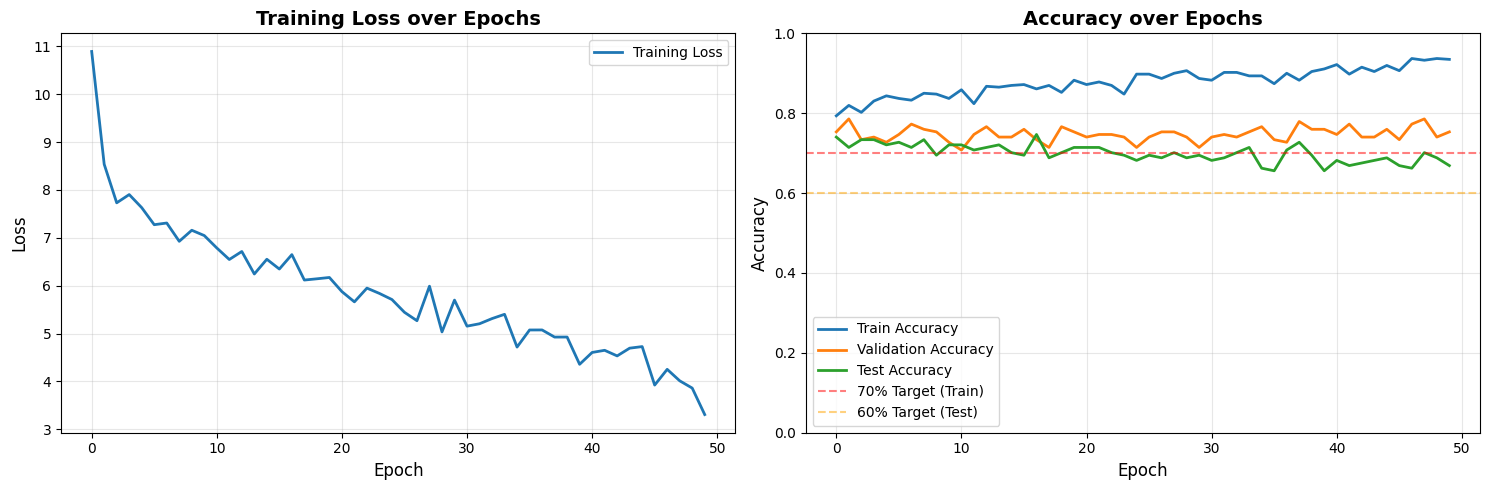


Performance Summary:
Final Train Accuracy:      93.48% ✓
Final Validation Accuracy: 75.32%
Final Test Accuracy:       66.88% ✓

Best Train Accuracy:       93.70%
Best Validation Accuracy:  78.57%
Best Test Accuracy:        74.68%


In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accuracies, label='Train Accuracy', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
ax2.plot(test_accuracies, label='Test Accuracy', linewidth=2)
ax2.axhline(y=0.70, color='r', linestyle='--', alpha=0.5, label='70% Target (Train)')
ax2.axhline(y=0.60, color='orange', linestyle='--', alpha=0.5, label='60% Target (Test)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"\nPerformance Summary:")
print(f"Final Train Accuracy:      {train_accuracies[-1]*100:.2f}% {'<-' if train_accuracies[-1] >= 0.70 else 'X'}")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.2f}%")
print(f"Final Test Accuracy:       {test_accuracies[-1]*100:.2f}% {'<-' if test_accuracies[-1] >= 0.60 else 'X'}")
print(f"\nBest Train Accuracy:       {max(train_accuracies)*100:.2f}%")
print(f"Best Validation Accuracy:  {max(val_accuracies)*100:.2f}%")
print(f"Best Test Accuracy:        {max(test_accuracies)*100:.2f}%")

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(model, X, y):
    X_tensor = Tensor(X, requires_grad=False)
    y_tensor = Tensor(y, requires_grad=False)
    
    predictions = model(X_tensor)
    pred_labels = (predictions.data >= 0.5).astype(int).flatten()
    true_labels = y_tensor.data.astype(int).flatten()
    
    metrics = {
        'accuracy': accuracy_score(true_labels, pred_labels),
        'precision': precision_score(true_labels, pred_labels, zero_division=0),
        'recall': recall_score(true_labels, pred_labels, zero_division=0),
        'f1': f1_score(true_labels, pred_labels, zero_division=0)
    }
    
    return metrics

train_metrics = calculate_metrics(model, X_train, y_train)
val_metrics = calculate_metrics(model, X_val, y_val)
test_metrics = calculate_metrics(model, X_test, y_test)

rows = []
rows.append(['Train', train_metrics['accuracy'], train_metrics['precision'], 
             train_metrics['recall'], train_metrics['f1']])
rows.append(['Validation', val_metrics['accuracy'], val_metrics['precision'], 
             val_metrics['recall'], val_metrics['f1']])
rows.append(['Test', test_metrics['accuracy'], test_metrics['precision'], 
             test_metrics['recall'], test_metrics['f1']])

df_metrics = pd.DataFrame(rows, columns=['Dataset', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

df_metrics[['Accuracy','Precision','Recall','F1-Score']] = df_metrics[['Accuracy','Precision','Recall','F1-Score']].applymap(lambda x: round(x, 4))

print("\nModel Performance Metrics:")
display(df_metrics)


Model Performance Metrics:


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_23400\634325272.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics[['Accuracy','Precision','Recall','F1-Score']] = df_metrics[['Accuracy','Precision','Recall','F1-Score']].applymap(lambda x: round(x, 4))


,Dataset,Accuracy,Precision,Recall,F1-Score
0,Train,0.9348,0.9396,0.8696,0.9032
1,Validation,0.7532,0.6739,0.5741,0.6200
2,Test,0.6688,0.5250,0.3962,0.4516
